## Trabajo Práctico 3: Detectando atributos de personas

### Grupo 4  

A partir de un conjunto de datos que contiene imagenes recortadas de personas, desarrollaremos un modelo que sea capaz de detectar si la persona tiene o no barba. Utilizaremos la columna "No_beard" como target. Los valores de salida pueden ser: "Sin Barba" y "Con Barba". 

### Setup inicial

#### Libs

In [2]:
import os

# Para especificar rutas de archivos y directorios
from pathlib import Path

# Lib para trabajar con arrays
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px

import seaborn as sns

# Lib que usamos para mostrar las imágenes
import matplotlib.pyplot as plt

# libs que usamos para construir y entrenar redes neuronales, y que además tiene utilidades para leer sets de 
# imágenes

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Input, Dropout, Convolution2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications import VGG16
from IPython.display import HTML, display

# Libs que usamos para tareas generales de machine learning. En este caso, métricas
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report,balanced_accuracy_score

# configuración para que las imágenes se vean dentro del notebook
%matplotlib inline

#### Datasets

In [3]:
#Path con la ruta con las imágenes
IMAGES_DIR = Path('./dataset/img_align_celeba/img_align_celeba/')
ATRIBUTOS_DIR = Path('./dataset/list_attr_celeba.csv')
PARTICIONES_DIR = Path('./dataset/list_eval_partition.csv')

In [4]:
#Variables a utilizar
SIZE = 70
IMAGES_CHANNELS = 3
BATCH_SIZE = 50

In [5]:
#Utilizamos solamente la columna "No_Beard"
data = pd.read_csv(ATRIBUTOS_DIR,sep=',',usecols=['image_id','No_Beard'])

In [6]:
#Reemplazamos los valores = 1 por 'Si' y los valores = -1 por 'No'
data['No_Beard']=data['No_Beard'].replace([1], 'No_Barba')
data['No_Beard']=data['No_Beard'].replace([-1], 'Barba')

In [7]:
#Datos divididos en diferentes conjuntos para armar: train, test y validation
data_partition = pd.read_csv(PARTICIONES_DIR,sep=',',usecols=['image_id','partition'])

In [8]:
#Unifico data_partition con data para dividir el dataset en conjuntos: train, test y validation
df_merge = pd.merge(data, data_partition, how='inner', on = 'image_id')

In [9]:
#Chequeo que se unifiquen todos
df_merge.partition.isnull().sum()

0

In [10]:
#Conjunto Train, Test, Validation

train = df_merge[df_merge['partition'] == 0]
test = df_merge[df_merge['partition'] == 1]
validation = df_merge[df_merge['partition'] == 2]

#Eliminamos la columna del nro de particion
train = train.drop(['partition'],axis = 1)
test = test.drop(['partition'],axis = 1)
validation = validation.drop(['partition'],axis = 1)

## 1. Análisis exploratorio sobre el conjunto de datos

In [11]:
# Función para devolver ejemplos del dataset
def sample_images(dataset, n, figsize=(10, 5), image_width=SIZE, image_height=SIZE):
    samples = data.sample(n)
    fig, axes = plt.subplots(1, n, figsize=figsize)

    datagen = ImageDataGenerator(rescale=1/255.0)

    for i in range(n):
        image = load_img(os.path.join(dataset, samples.iloc[i]['image_id']))
        image = image.resize((image_width, image_height))
        image = img_to_array(image)
        image = datagen.standardize(image)

        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(f"{samples.iloc[i]['No_Beard']}")

    plt.tight_layout()
    plt.show()


#### Volumetría de los datos

In [12]:
print("Cantidad total de imágenes:", len(df_merge))


Cantidad total de imágenes: 202599


#### Distribución de la variable a predecir

Text(0.5, 1.0, 'Distribución conjunto total')

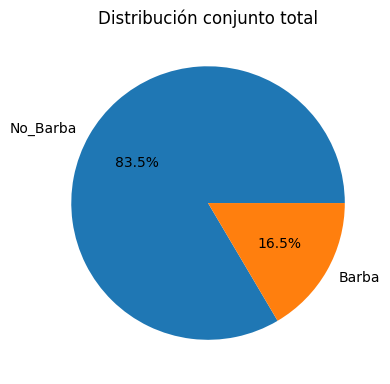

In [13]:
vals_df = df_merge.No_Beard.value_counts()
names_df = vals_df.index
fig = plt.figure(figsize=(15, 5))

ax_train = fig.add_subplot(1, 3, 1)
ax_train.pie(vals_df, labels=names_df, autopct='%1.1f%%')
ax_train.set_title('Distribución conjunto total')

Podemos ver en los gráficos que la variable target se encuentra desbalanceada. Más del 80% de las imágenes de las personas en el dataset, no tienen barba. 

#### Balanceo del dataset

Realizamos undersampling para eliminar aleatoriamente muestras de la clase mayoritaria y así poder igualar el número de muestras de la clase minoritaria.

In [14]:
target_count = df_merge["No_Beard"].value_counts()
higher_category = list(target_count.index)[0]
np.random.seed(42)
indices = df_merge[df_merge["No_Beard"] == higher_category].index
sample_size = target_count[0] - target_count[1]

drop_sample = np.random.choice(indices, sample_size, replace = False)
df_merge_opt = df_merge.drop(drop_sample, axis = "index")

Text(0.5, 1.0, 'Distribución conjunto total')

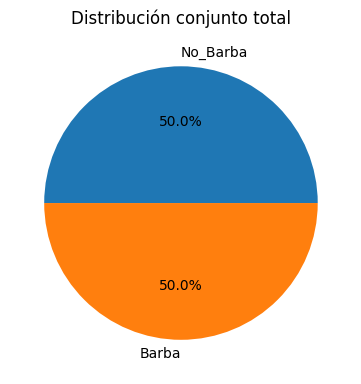

In [15]:
vals_df = df_merge_opt.No_Beard.value_counts()
names_df = vals_df.index
fig = plt.figure(figsize=(15, 5))

ax_train = fig.add_subplot(1, 3, 1)
ax_train.pie(vals_df, labels=names_df, autopct='%1.1f%%')
ax_train.set_title('Distribución conjunto total')

In [16]:
train = df_merge_opt[df_merge_opt['partition'] == 0]
test = df_merge_opt[df_merge_opt['partition'] == 1]
validation = df_merge_opt[df_merge_opt['partition'] == 2]

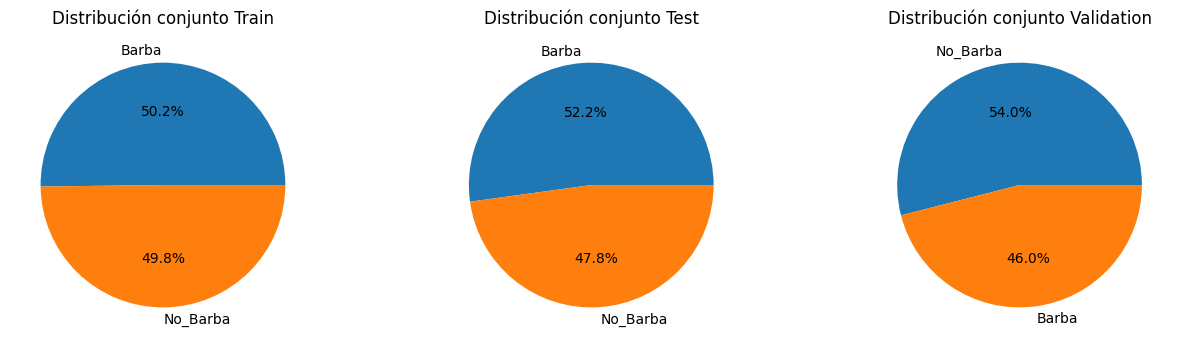

In [17]:
vals_train = train.No_Beard.value_counts()
names_train = vals_train.index
fig = plt.figure(figsize=(15, 5))

ax_train = fig.add_subplot(1, 3, 1)
ax_train.pie(vals_train, labels=names_train, autopct='%1.1f%%')
ax_train.set_title('Distribución conjunto Train')


vals_test = test.No_Beard.value_counts()
names_test = vals_test.index
ax_test = fig.add_subplot(1, 3, 2)
ax_test.pie(vals_test, labels=names_test, autopct='%1.1f%%')
ax_test.set_title('Distribución conjunto Test')

vals_val = validation.No_Beard.value_counts()
names_val = vals_val.index
ax_val = fig.add_subplot(1, 3, 3)
ax_val.pie(vals_val, labels=names_val, autopct='%1.1f%%')
ax_val.set_title('Distribución conjunto Validation')

plt.subplots_adjust(wspace=0.4)

plt.show()

In [18]:
print("Cantidad de imágenes y dimensiones en Train:", train.shape)

Cantidad de imágenes y dimensiones en Train: (53770, 3)


In [19]:
print("Cantidad de imágenes y dimensiones en Test:", test.shape)

Cantidad de imágenes y dimensiones en Test: (6764, 3)


In [19]:
print("Cantidad de imágenes y dimensiones en Validation:", validation.shape)

Cantidad de imágenes y dimensiones en Validation: (6348, 3)


#### Estructura y tipo de las imágenes

El conjunto de imágenes originales tienen una dimensión de 178x218 pixeles y son a color, por lo tanto tienen 3 canales de profundidad. 

##### Ejemplos de las imágenes originales

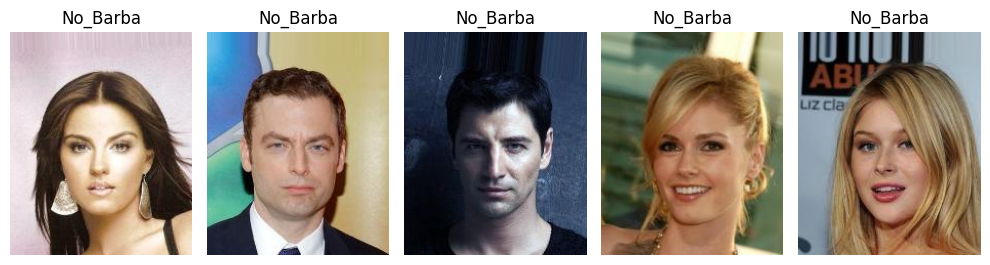

In [20]:
sample_images(IMAGES_DIR, 5, figsize=(10, 5), image_width=178, image_height=218)

##### Ejemplos de las imágenes modificadas en tamaño y reescaladas. 

No contamos con una GPU para entrenar los modelos, por lo tanto: 
- Reducimos el tamaño a 70x70 pixeles: de esta manera, cada modelo tiene que aprender una menor cantidad de pesos, entonces, los resultados se obtienen más rápido. 
- Reescalamos los valores de las imágenes entre 0 y 1. 

In [20]:
#Lector de imágenes que se encarga de reescalarlas. 
images_reader = ImageDataGenerator(
    rescale=1/255
)

#Definimos un generador de DataFrame para cada conjunto de Datos. 

train_generator = images_reader.flow_from_dataframe(
    #DataFrame que contiene el nombre de las imagenes y la variable target. 
    dataframe = train,
    #Path que contiene todas las imágenes
    directory=IMAGES_DIR,
    #Columna del DataFrame que contiene el nombre de las imágenes
    x_col='image_id',
    #Columna target del DataFrame. 
    y_col='No_Beard',
    class_mode="binary",
    batch_size=BATCH_SIZE,
    shuffle=False,
    target_size=(SIZE, SIZE)
)

test_generator = images_reader.flow_from_dataframe(
    #DataFrame que contiene el nombre de las imagenes y la variable target. 
    dataframe = test,
    #Path que contiene todas las imágenes
    directory=IMAGES_DIR,
    #Columna del DataFrame que contiene el nombre de las imágenes
    x_col='image_id',
    #Columna target del DataFrame. 
    y_col='No_Beard',
    class_mode="binary",
    batch_size=BATCH_SIZE,
    shuffle=False,
    target_size=(SIZE, SIZE)
)

validation_generator = images_reader.flow_from_dataframe(
    #DataFrame que contiene el nombre de las imagenes y la variable target. 
    dataframe = validation,
    #Path que contiene todas las imágenes
    directory=IMAGES_DIR,
    #Columna del DataFrame que contiene el nombre de las imágenes
    x_col='image_id',
    #Columna target del DataFrame. 
    y_col='No_Beard',
    class_mode="binary",
    batch_size=BATCH_SIZE,
    shuffle=False,
    target_size=(SIZE, SIZE)
)

Found 53770 validated image filenames belonging to 2 classes.
Found 6764 validated image filenames belonging to 2 classes.
Found 6348 validated image filenames belonging to 2 classes.


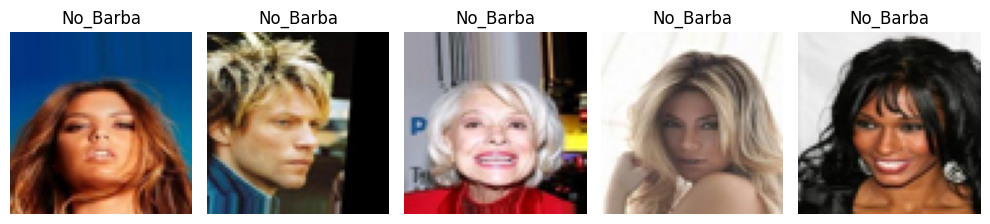

In [22]:
sample_images(IMAGES_DIR, 5)

## 2. Machine Learning

In [21]:
### Función para graficar la curva de aprendizaje: 
def learning_curve(historial):
    plt.plot(historial.history['accuracy'], label='train')
    plt.plot(historial.history['val_accuracy'], label='test')
    plt.title('Accuracy durante el entrenamiento')
    plt.ylabel('Accuracy')
    plt.xlabel('Época')
    plt.legend(loc='upper left')
    plt.show()

## - Multi Layer Perceptron (MLP)

Para las redes neuronales de tipo MLP utilizamos los siguientes parámetros en común: 
- Primer capa **Flatten** que recibe una imágen de 70x70x3. 
- Función de activación en la capa de salida: **Sigmoide**. 
- Se trata de una clasificación binaria, que indica si la imágen de la persona tiene barba (No_Beard = 1) o no (No_Beard = 0). Utilizamos una función de error de tipo **Binary_crossentropy** ya que son redes que tienen una sóla salida entre 0 y 1. 
- La métrica utilizada es "Accuracy" ya que la distribución de la variable target está balanceada. 
- Empezamos utilizando 10 épocas, luego fuimos variando según cada caso. 
- El resto de los hiperparámetros lo fuimos modificando para cada red neuronal propuesta. 

**Red Neuronal 1:**
- MLP
- Capas ocultas: 2 densas, con 20 neuronas y 15 neuronas. 
- Capa de salida: Densa con 1 neurona. 
- Dropout: no utilizado.
- Función de activación: "relu" para las primeras capas. 
- Épocas: 10. 
- Tamaño de Batch: 128


In [24]:
model_mlp_1 = Sequential([
    Flatten(input_shape=(SIZE,SIZE,IMAGES_CHANNELS)), 
    
    Dense(20, activation='relu'),
    Dense(15, activation='relu'),
    
    Dense(1, activation='sigmoid'),
])

model_mlp_1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy',],
)
    
model_mlp_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 14700)             0         
                                                                 
 dense (Dense)               (None, 20)                294020    
                                                                 
 dense_1 (Dense)             (None, 15)                315       
                                                                 
 dense_2 (Dense)             (None, 1)                 16        
                                                                 
Total params: 294,351
Trainable params: 294,351
Non-trainable params: 0
_________________________________________________________________


In [25]:
history_mlp_1 = model_mlp_1.fit(
    train_generator,
    epochs=10,
    batch_size=128,
    validation_data=test_generator
)

Epoch 1/10
1076/1076 [==============================] - 32s 29ms/step - loss: 0.4829 - accuracy: 0.7654 - val_loss: 0.3837 - val_accuracy: 0.8227
Epoch 2/10
1076/1076 [==============================] - 31s 29ms/step - loss: 0.3892 - accuracy: 0.8224 - val_loss: 0.3844 - val_accuracy: 0.8255
Epoch 3/10
1076/1076 [==============================] - 31s 29ms/step - loss: 0.3695 - accuracy: 0.8303 - val_loss: 0.3433 - val_accuracy: 0.8415
Epoch 4/10
1076/1076 [==============================] - 31s 29ms/step - loss: 0.3558 - accuracy: 0.8347 - val_loss: 0.3343 - val_accuracy: 0.8455
Epoch 5/10
1076/1076 [==============================] - 31s 29ms/step - loss: 0.3398 - accuracy: 0.8446 - val_loss: 0.3555 - val_accuracy: 0.8325
Epoch 6/10
1076/1076 [==============================] - 31s 29ms/step - loss: 0.3321 - accuracy: 0.8472 - val_loss: 0.3254 - val_accuracy: 0.8443
Epoch 7/10
1076/1076 [==============================] - 31s 29ms/step - loss: 0.3271 - accuracy: 0.8492 - val_loss: 0.3192 -

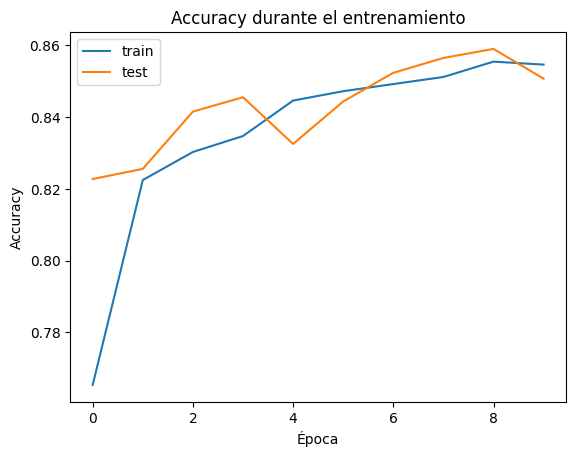

In [27]:
learning_curve(history_mlp_1)

**Red Neuronal 1.1:**
- MLP
- Capas ocultas: 2 densas, con 20 neuronas y 15 neuronas. 
- Capa de salida: Densa con 1 neurona. 
- **Dropout: 20%**
- Función de activación: "relu" para las primeras capas. 
- Épocas: 10. 
- Tamaño de Batch: 128

In [46]:
model_mlp_1_do = Sequential([
    Flatten(input_shape=(SIZE,SIZE,IMAGES_CHANNELS)), 
    
    Dense(20, activation='relu'),
    Dropout(0.20),
    Dense(15, activation='relu'),
    Dropout(0.20),
    
    Dense(1, activation='sigmoid'),
])

model_mlp_1_do.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy',],
)
    
model_mlp_1_do.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 14700)             0         
                                                                 
 dense_71 (Dense)            (None, 20)                294020    
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_72 (Dense)            (None, 15)                315       
                                                                 
 dropout_1 (Dropout)         (None, 15)                0         
                                                                 
 dense_73 (Dense)            (None, 1)                 16        
                                                                 
Total params: 294,351
Trainable params: 294,351
Non-tr

In [47]:
history_mlp_1_do = model_mlp_1_do.fit(
    train_generator,
    epochs=10,
    batch_size=128,
    validation_data=test_generator
)

Epoch 1/10
1076/1076 [==============================] - 37s 34ms/step - loss: 0.6943 - accuracy: 0.5071 - val_loss: 0.6930 - val_accuracy: 0.5217
Epoch 2/10
1076/1076 [==============================] - 30s 28ms/step - loss: 0.6932 - accuracy: 0.4996 - val_loss: 0.6931 - val_accuracy: 0.5217
Epoch 3/10
1076/1076 [==============================] - 30s 28ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6930 - val_accuracy: 0.5217
Epoch 4/10
1076/1076 [==============================] - 31s 29ms/step - loss: 0.6932 - accuracy: 0.4994 - val_loss: 0.6931 - val_accuracy: 0.5217
Epoch 5/10
1076/1076 [==============================] - 31s 28ms/step - loss: 0.6932 - accuracy: 0.4987 - val_loss: 0.6931 - val_accuracy: 0.5217
Epoch 6/10
1076/1076 [==============================] - 30s 28ms/step - loss: 0.6932 - accuracy: 0.4993 - val_loss: 0.6928 - val_accuracy: 0.5217
Epoch 7/10
1076/1076 [==============================] - 30s 28ms/step - loss: 0.6932 - accuracy: 0.5020 - val_loss: 0.6929 -

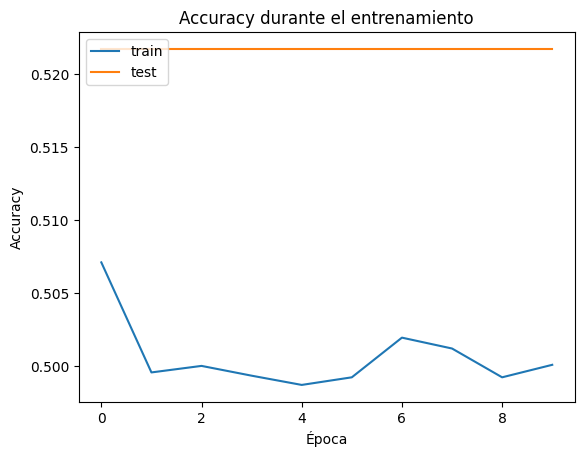

In [48]:
learning_curve(history_mlp_1_do)

**Red Neuronal 1.2:**

- MLP
- Capas ocultas: 2 densas, con 20 neuronas y 15 neuronas.
- Capa de salida: Densa con 1 neurona.
- Dropout: no utilizado.
- Función de activación: "relu" para las primeras capas.
- **Épocas: 20**
- Tamaño de Batch: 128

In [30]:
history_mlp_1 = model_mlp_1.fit(
    train_generator,
    epochs=20,
    batch_size=128,
    validation_data=test_generator
)

Epoch 1/20
1076/1076 [==============================] - 32s 30ms/step - loss: 0.3067 - accuracy: 0.8593 - val_loss: 0.3158 - val_accuracy: 0.8495
Epoch 2/20
1076/1076 [==============================] - 32s 30ms/step - loss: 0.2999 - accuracy: 0.8620 - val_loss: 0.3085 - val_accuracy: 0.8563
Epoch 3/20
1076/1076 [==============================] - 32s 30ms/step - loss: 0.3024 - accuracy: 0.8616 - val_loss: 0.3393 - val_accuracy: 0.8423
Epoch 4/20
1076/1076 [==============================] - 32s 30ms/step - loss: 0.2965 - accuracy: 0.8653 - val_loss: 0.2987 - val_accuracy: 0.8625
Epoch 5/20
1076/1076 [==============================] - 33s 30ms/step - loss: 0.2968 - accuracy: 0.8647 - val_loss: 0.4075 - val_accuracy: 0.7926
Epoch 6/20
1076/1076 [==============================] - 33s 30ms/step - loss: 0.2983 - accuracy: 0.8634 - val_loss: 0.3007 - val_accuracy: 0.8606
Epoch 7/20
1076/1076 [==============================] - 32s 30ms/step - loss: 0.2902 - accuracy: 0.8682 - val_loss: 0.3251 -

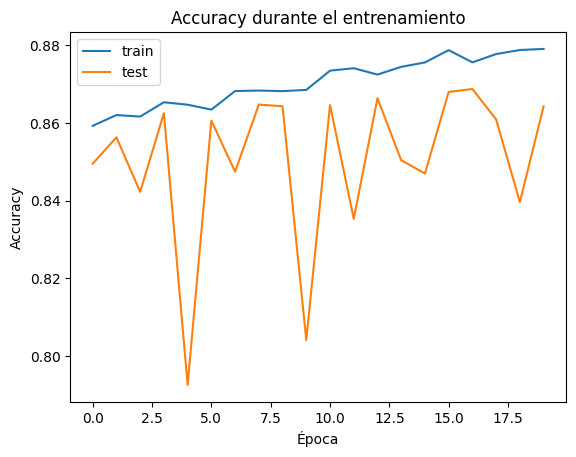

In [31]:
learning_curve(history_mlp_1)

**Red Neuronal 1.3:**

- MLP
- Capas ocultas: 2 densas, con 20 neuronas y 15 neuronas.
- Capa de salida: Densa con 1 neurona.
- Dropout: no utilizado.
- Función de activación: "relu" para las primeras capas.
- **Épocas: 80**
- Tamaño de Batch: 128

In [45]:
history_mlp_1_1 = model_mlp_1.fit(
    train_generator,
    epochs=80,
    batch_size=128,
    validation_data=test_generator
)

Epoch 1/80
1076/1076 [==============================] - 30s 28ms/step - loss: 0.4939 - accuracy: 0.7586 - val_loss: 0.3998 - val_accuracy: 0.8155
Epoch 2/80
1076/1076 [==============================] - 30s 28ms/step - loss: 0.3911 - accuracy: 0.8206 - val_loss: 0.3656 - val_accuracy: 0.8350
Epoch 3/80
1076/1076 [==============================] - 30s 28ms/step - loss: 0.3652 - accuracy: 0.8333 - val_loss: 0.3348 - val_accuracy: 0.8462
Epoch 4/80
1076/1076 [==============================] - 30s 28ms/step - loss: 0.3530 - accuracy: 0.8386 - val_loss: 0.3751 - val_accuracy: 0.8297
Epoch 5/80
1076/1076 [==============================] - 30s 28ms/step - loss: 0.3384 - accuracy: 0.8453 - val_loss: 0.3186 - val_accuracy: 0.8533
Epoch 6/80
1076/1076 [==============================] - 30s 28ms/step - loss: 0.3365 - accuracy: 0.8472 - val_loss: 0.3514 - val_accuracy: 0.8368
Epoch 7/80
1076/1076 [==============================] - 30s 28ms/step - loss: 0.3314 - accuracy: 0.8504 - val_loss: 0.3482 -

Epoch 57/80
1076/1076 [==============================] - 30s 28ms/step - loss: 0.2561 - accuracy: 0.8883 - val_loss: 0.3167 - val_accuracy: 0.8581
Epoch 58/80
1076/1076 [==============================] - 30s 28ms/step - loss: 0.2557 - accuracy: 0.8881 - val_loss: 0.2915 - val_accuracy: 0.8696
Epoch 59/80
1076/1076 [==============================] - 30s 28ms/step - loss: 0.2520 - accuracy: 0.8906 - val_loss: 0.3187 - val_accuracy: 0.8582
Epoch 60/80
1076/1076 [==============================] - 30s 28ms/step - loss: 0.2518 - accuracy: 0.8909 - val_loss: 0.3308 - val_accuracy: 0.8556
Epoch 61/80
1076/1076 [==============================] - 30s 28ms/step - loss: 0.2554 - accuracy: 0.8880 - val_loss: 0.2955 - val_accuracy: 0.8640
Epoch 62/80
1076/1076 [==============================] - 30s 28ms/step - loss: 0.2542 - accuracy: 0.8893 - val_loss: 0.2850 - val_accuracy: 0.8717
Epoch 63/80
1076/1076 [==============================] - 63435s 59s/step - loss: 0.2536 - accuracy: 0.8892 - val_loss:

**Red Neuronal 2:**
- MLP
- Capas ocultas: 2 densas, con 20 neuronas y 15 neuronas. 
- Capa de salida: Densa con 1 neurona. 
- Dropout: no utilizado.
- Función de activación: **"tanh"** para las primeras capas. 
- Épocas: 10. 
- Tamaño de Batch: 128

In [25]:
model_mlp_2 = Sequential([
    Flatten(input_shape=(SIZE,SIZE,IMAGES_CHANNELS)), 
    
    Dense(20, activation='tanh'),
    Dense(15, activation='tanh'),
    
    Dense(1, activation='sigmoid'),
])

model_mlp_2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy',],
)
    
model_mlp_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 14700)             0         
                                                                 
 dense_3 (Dense)             (None, 20)                294020    
                                                                 
 dense_4 (Dense)             (None, 15)                315       
                                                                 
 dense_5 (Dense)             (None, 1)                 16        
                                                                 
Total params: 294,351
Trainable params: 294,351
Non-trainable params: 0
_________________________________________________________________


In [29]:
history_mlp_2 = model_mlp_2.fit(
    train_generator,
    epochs=10,
    batch_size=128,
    validation_data=test_generator
)

Epoch 1/10
1076/1076 [==============================] - 34s 31ms/step - loss: 0.6945 - accuracy: 0.5009 - val_loss: 0.6934 - val_accuracy: 0.4783
Epoch 2/10
1076/1076 [==============================] - 33s 30ms/step - loss: 0.6936 - accuracy: 0.5039 - val_loss: 0.6962 - val_accuracy: 0.4783
Epoch 3/10
1076/1076 [==============================] - 32s 30ms/step - loss: 0.6935 - accuracy: 0.5039 - val_loss: 0.6946 - val_accuracy: 0.4783
Epoch 4/10
1076/1076 [==============================] - 33s 31ms/step - loss: 0.6931 - accuracy: 0.5038 - val_loss: 0.6908 - val_accuracy: 0.5217
Epoch 5/10
1076/1076 [==============================] - 33s 31ms/step - loss: 0.6927 - accuracy: 0.5067 - val_loss: 0.6911 - val_accuracy: 0.5038
Epoch 6/10
1076/1076 [==============================] - 33s 30ms/step - loss: 0.6908 - accuracy: 0.5173 - val_loss: 0.6894 - val_accuracy: 0.5217
Epoch 7/10
1076/1076 [==============================] - 33s 30ms/step - loss: 0.6865 - accuracy: 0.5369 - val_loss: 0.6781 -

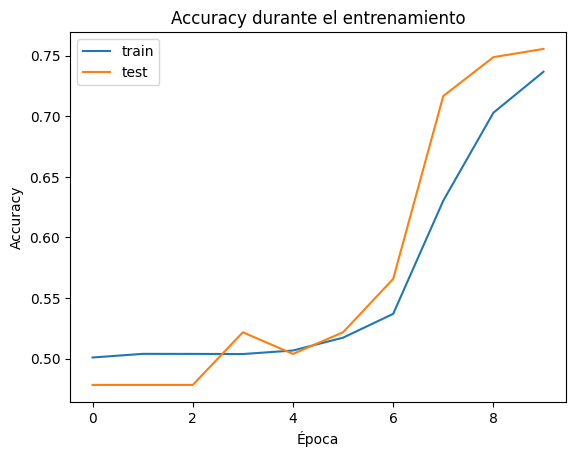

In [32]:
learning_curve(history_mlp_2)

**Red Neuronal 2.1:**
- MLP
- Capas ocultas: 2 densas, con 20 neuronas y 15 neuronas. 
- Capa de salida: Densa con 1 neurona. 
- Dropout: no utilizado.
- Función de activación: **"tanh"** para las primeras capas. 
- **Épocas: 30.**
- Tamaño de Batch: 128

In [24]:
history_mlp_4 = model_mlp_2.fit(
    train_generator,
    epochs=30,
    batch_size=128,
    validation_data=test_generator
)

Epoch 1/30
1076/1076 [==============================] - 38s 35ms/step - loss: 0.7060 - accuracy: 0.5025 - val_loss: 0.6924 - val_accuracy: 0.5217
Epoch 2/30
1076/1076 [==============================] - 31s 29ms/step - loss: 0.6942 - accuracy: 0.4983 - val_loss: 0.6926 - val_accuracy: 0.5217
Epoch 3/30
1076/1076 [==============================] - 31s 29ms/step - loss: 0.6939 - accuracy: 0.5026 - val_loss: 0.6929 - val_accuracy: 0.5217
Epoch 4/30
1076/1076 [==============================] - 31s 29ms/step - loss: 0.6939 - accuracy: 0.4999 - val_loss: 0.6945 - val_accuracy: 0.4783
Epoch 5/30
1076/1076 [==============================] - 31s 29ms/step - loss: 0.6939 - accuracy: 0.5026 - val_loss: 0.6930 - val_accuracy: 0.5217
Epoch 6/30
1076/1076 [==============================] - 31s 29ms/step - loss: 0.6937 - accuracy: 0.4993 - val_loss: 0.6962 - val_accuracy: 0.4783
Epoch 7/30
1076/1076 [==============================] - 31s 29ms/step - loss: 0.6937 - accuracy: 0.4973 - val_loss: 0.6958 -

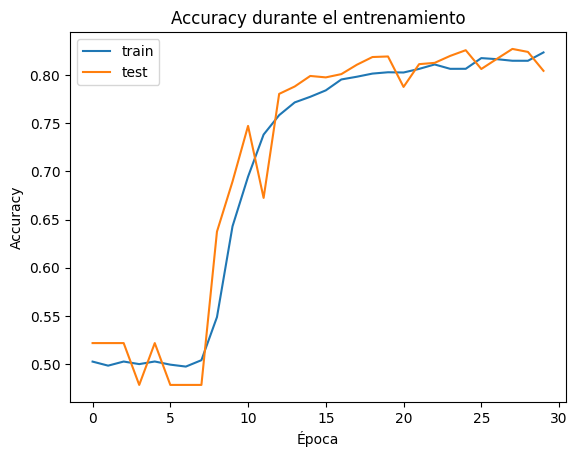

In [25]:
learning_curve(history_mlp_4)

**Red Neuronal 2.2:**
- MLP
- Capas ocultas: 2 densas, con 20 neuronas y 15 neuronas. 
- Capa de salida: Densa con 1 neurona. 
- Dropout: no utilizado.
- Función de activación: **"tanh"** para las primeras capas. 
- **Épocas: 80.**
- Tamaño de Batch: 128

In [26]:
history_mlp_5 = model_mlp_2.fit(
    train_generator,
    epochs=80,
    batch_size=128,
    validation_data=test_generator
)

Epoch 1/80
1076/1076 [==============================] - 31s 28ms/step - loss: 0.6933 - accuracy: 0.5073 - val_loss: 0.6957 - val_accuracy: 0.4783
Epoch 2/80
1076/1076 [==============================] - 31s 28ms/step - loss: 0.6939 - accuracy: 0.5014 - val_loss: 0.6922 - val_accuracy: 0.5217
Epoch 3/80
1076/1076 [==============================] - 31s 28ms/step - loss: 0.6937 - accuracy: 0.5001 - val_loss: 0.7008 - val_accuracy: 0.4783
Epoch 4/80
1076/1076 [==============================] - 31s 28ms/step - loss: 0.6930 - accuracy: 0.5075 - val_loss: 0.6908 - val_accuracy: 0.5217
Epoch 5/80
1076/1076 [==============================] - 31s 28ms/step - loss: 0.6916 - accuracy: 0.5126 - val_loss: 0.6917 - val_accuracy: 0.4867
Epoch 6/80
1076/1076 [==============================] - 31s 28ms/step - loss: 0.6914 - accuracy: 0.5120 - val_loss: 0.6928 - val_accuracy: 0.5219
Epoch 7/80
1076/1076 [==============================] - 31s 28ms/step - loss: 0.6935 - accuracy: 0.5003 - val_loss: 0.6928 -

Epoch 57/80
1076/1076 [==============================] - 30s 28ms/step - loss: 0.4179 - accuracy: 0.8456 - val_loss: 0.4223 - val_accuracy: 0.8390
Epoch 58/80
1076/1076 [==============================] - 30s 28ms/step - loss: 0.4093 - accuracy: 0.8514 - val_loss: 0.4403 - val_accuracy: 0.8295
Epoch 59/80
1076/1076 [==============================] - 30s 28ms/step - loss: 0.4088 - accuracy: 0.8513 - val_loss: 0.4148 - val_accuracy: 0.8486
Epoch 60/80
1076/1076 [==============================] - 30s 28ms/step - loss: 0.4119 - accuracy: 0.8498 - val_loss: 0.4056 - val_accuracy: 0.8529
Epoch 61/80
1076/1076 [==============================] - 30s 28ms/step - loss: 0.4041 - accuracy: 0.8537 - val_loss: 0.4309 - val_accuracy: 0.8325
Epoch 62/80
1076/1076 [==============================] - 30s 28ms/step - loss: 0.4048 - accuracy: 0.8532 - val_loss: 0.4088 - val_accuracy: 0.8535
Epoch 63/80
1076/1076 [==============================] - 30s 28ms/step - loss: 0.4031 - accuracy: 0.8547 - val_loss: 0

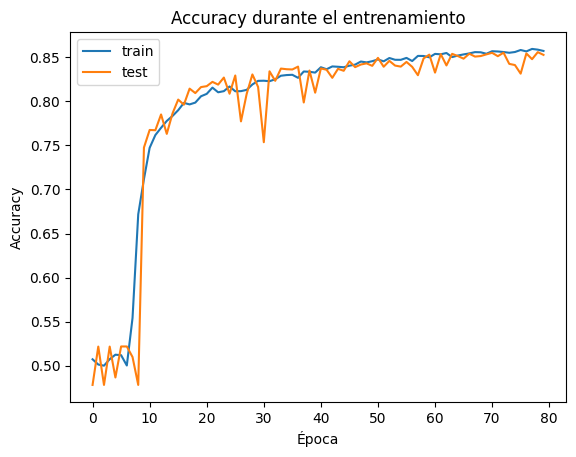

In [27]:
learning_curve(history_mlp_5)

**Red Neuronal 3:**
- MLP
- Capas ocultas: **5 capas densas con 20 neuronas y 5 capas densas con 15 neuronas.**
- Capa de salida: Densa con 1 neurona. 
- Dropout: no utilizado.
- Función de activación: **"relu"** para las primeras capas. 
- **Épocas: 20.**
- Tamaño de Batch: 128

In [34]:
model_mlp_3 = Sequential([
    Flatten(input_shape=(SIZE,SIZE,IMAGES_CHANNELS)), 
    
    Dense(20, activation='relu'),
    Dense(20, activation='relu'),
    Dense(20, activation='relu'),
    Dense(20, activation='relu'),
    Dense(20, activation='relu'),
    Dense(15, activation='relu'),
    Dense(15, activation='relu'),
    Dense(15, activation='relu'),
    Dense(15, activation='relu'),
    Dense(15, activation='relu'),
    
    Dense(1, activation='sigmoid'),
])

model_mlp_3.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy',],
)
    
model_mlp_3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 14700)             0         
                                                                 
 dense_28 (Dense)            (None, 20)                294020    
                                                                 
 dense_29 (Dense)            (None, 20)                420       
                                                                 
 dense_30 (Dense)            (None, 20)                420       
                                                                 
 dense_31 (Dense)            (None, 20)                420       
                                                                 
 dense_32 (Dense)            (None, 20)                420       
                                                                 
 dense_33 (Dense)            (None, 15)               

In [35]:
history_mlp_6 = model_mlp_3.fit(
    train_generator,
    epochs=20,
    batch_size=128,
    validation_data=test_generator
)

Epoch 1/20
1076/1076 [==============================] - 35s 32ms/step - loss: 0.4956 - accuracy: 0.7533 - val_loss: 0.3727 - val_accuracy: 0.8258
Epoch 2/20
1076/1076 [==============================] - 31s 29ms/step - loss: 0.3909 - accuracy: 0.8155 - val_loss: 0.3405 - val_accuracy: 0.8427
Epoch 3/20
1076/1076 [==============================] - 31s 29ms/step - loss: 0.3529 - accuracy: 0.8378 - val_loss: 0.3245 - val_accuracy: 0.8482
Epoch 4/20
1076/1076 [==============================] - 31s 29ms/step - loss: 0.3449 - accuracy: 0.8398 - val_loss: 0.3539 - val_accuracy: 0.8291
Epoch 5/20
1076/1076 [==============================] - 31s 29ms/step - loss: 0.3369 - accuracy: 0.8444 - val_loss: 0.3223 - val_accuracy: 0.8424
Epoch 6/20
1076/1076 [==============================] - 31s 29ms/step - loss: 0.3296 - accuracy: 0.8477 - val_loss: 0.3862 - val_accuracy: 0.8180
Epoch 7/20
1076/1076 [==============================] - 31s 29ms/step - loss: 0.3212 - accuracy: 0.8505 - val_loss: 0.3221 -

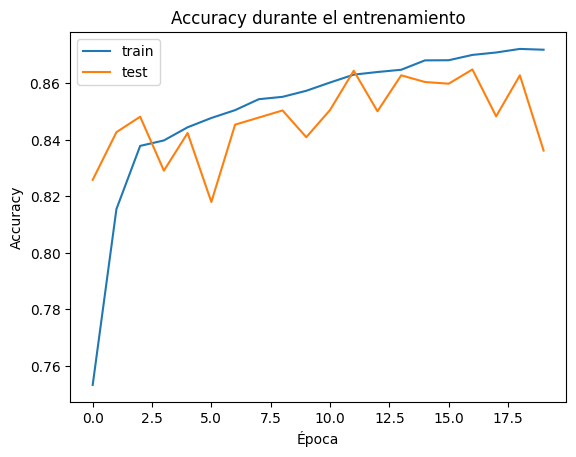

In [36]:
learning_curve(history_mlp_6)

**Red Neuronal 3.1:**
- MLP
- Capas ocultas: 5 capas densas con **50 neuronas** y 5 capas densas con **30 neuronas**. 
- Capa de salida: Densa con 1 neurona. 
- Dropout: no utilizado.
- Función de activación: **"relu"** para las primeras capas. 
- **Épocas: 20.**
- Tamaño de Batch: 128

In [37]:
model_mlp_3_1 = Sequential([
    Flatten(input_shape=(SIZE,SIZE,IMAGES_CHANNELS)), 
    
    Dense(50, activation='relu'),
    Dense(50, activation='relu'),
    Dense(50, activation='relu'),
    Dense(50, activation='relu'),
    Dense(50, activation='relu'),
    Dense(30, activation='relu'),
    Dense(30, activation='relu'),
    Dense(30, activation='relu'),
    Dense(30, activation='relu'),
    Dense(30, activation='relu'),
    
    Dense(1, activation='sigmoid'),
])

model_mlp_3_1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy',],
)
    
model_mlp_3_1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 14700)             0         
                                                                 
 dense_39 (Dense)            (None, 50)                735050    
                                                                 
 dense_40 (Dense)            (None, 50)                2550      
                                                                 
 dense_41 (Dense)            (None, 50)                2550      
                                                                 
 dense_42 (Dense)            (None, 50)                2550      
                                                                 
 dense_43 (Dense)            (None, 50)                2550      
                                                                 
 dense_44 (Dense)            (None, 30)               

In [38]:
history_mlp_7 = model_mlp_3_1.fit(
    train_generator,
    epochs=20,
    batch_size=128,
    validation_data=test_generator
)

Epoch 1/20
1076/1076 [==============================] - 35s 31ms/step - loss: 0.4972 - accuracy: 0.7462 - val_loss: 0.3762 - val_accuracy: 0.8251
Epoch 2/20
1076/1076 [==============================] - 33s 31ms/step - loss: 0.3820 - accuracy: 0.8198 - val_loss: 0.4028 - val_accuracy: 0.8037
Epoch 3/20
1076/1076 [==============================] - 33s 31ms/step - loss: 0.3559 - accuracy: 0.8324 - val_loss: 0.3342 - val_accuracy: 0.8489
Epoch 4/20
1076/1076 [==============================] - 33s 31ms/step - loss: 0.3442 - accuracy: 0.8378 - val_loss: 0.3270 - val_accuracy: 0.8399
Epoch 5/20
1076/1076 [==============================] - 33s 31ms/step - loss: 0.3345 - accuracy: 0.8431 - val_loss: 0.3287 - val_accuracy: 0.8496
Epoch 6/20
1076/1076 [==============================] - 33s 31ms/step - loss: 0.3278 - accuracy: 0.8489 - val_loss: 0.3220 - val_accuracy: 0.8482
Epoch 7/20
1076/1076 [==============================] - 33s 31ms/step - loss: 0.3177 - accuracy: 0.8534 - val_loss: 0.3231 -

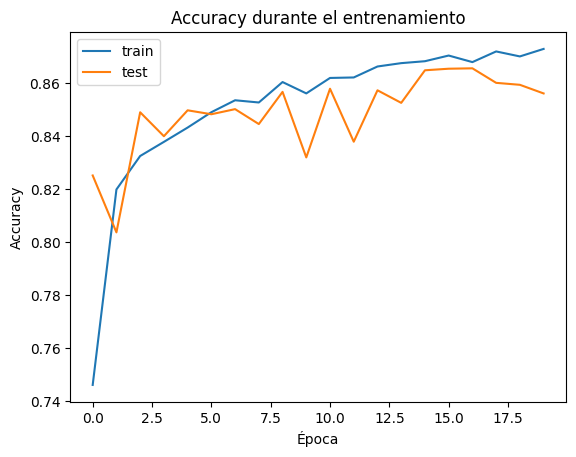

In [41]:
learning_curve(history_mlp_7)

**Red Neuronal 3.2:**
- MLP
- Capas ocultas: 5 capas densas con **50 neuronas** y 5 capas densas con **30 neuronas**. 
- Capa de salida: Densa con 1 neurona. 
- Dropout: no utilizado.
- Función de activación: **"relu"** para las primeras capas. 
- **Épocas: 40.**
- Tamaño de Batch: 128

In [43]:
history_mlp_7_1 = model_mlp_3_1.fit(
    train_generator,
    epochs=40,
    batch_size=128,
    validation_data=test_generator
)

Epoch 1/40
1076/1076 [==============================] - 32s 30ms/step - loss: 0.2804 - accuracy: 0.8723 - val_loss: 0.2982 - val_accuracy: 0.8603
Epoch 2/40
1076/1076 [==============================] - 32s 30ms/step - loss: 0.2812 - accuracy: 0.8715 - val_loss: 0.2873 - val_accuracy: 0.8678
Epoch 3/40
1076/1076 [==============================] - 33s 30ms/step - loss: 0.2770 - accuracy: 0.8734 - val_loss: 0.3332 - val_accuracy: 0.8486
Epoch 4/40
1076/1076 [==============================] - 32s 30ms/step - loss: 0.2745 - accuracy: 0.8746 - val_loss: 0.3151 - val_accuracy: 0.8596
Epoch 5/40
1076/1076 [==============================] - 32s 30ms/step - loss: 0.2753 - accuracy: 0.8753 - val_loss: 0.2889 - val_accuracy: 0.8693
Epoch 6/40
1076/1076 [==============================] - 32s 30ms/step - loss: 0.2660 - accuracy: 0.8810 - val_loss: 0.3088 - val_accuracy: 0.8545
Epoch 7/40
1076/1076 [==============================] - 32s 30ms/step - loss: 0.2652 - accuracy: 0.8811 - val_loss: 0.3064 -

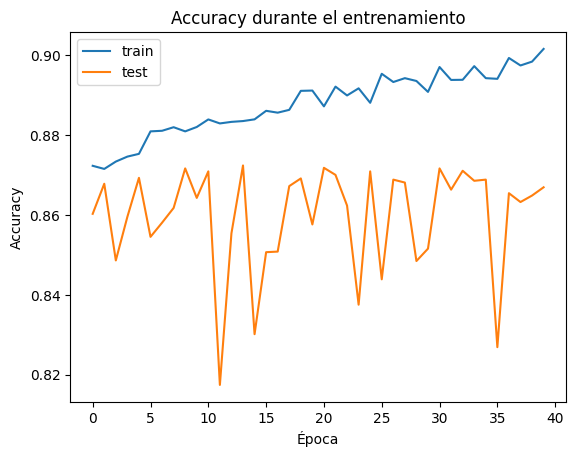

In [44]:
learning_curve(history_mlp_7_1)

**Red Neuronal 4:**
- MLP
- Capas ocultas: **10 capas densas con 20 neuronas y 10 capas densas con 15 neuronas.**
- Capa de salida: Densa con 1 neurona. 
- Dropout: no utilizado.
- Función de activación: **"relu"** para las primeras capas. 
- **Épocas: 40.**
- Tamaño de Batch: 128

In [39]:
model_mlp_4 = Sequential([
    Flatten(input_shape=(SIZE,SIZE,IMAGES_CHANNELS)), 
    
    Dense(20, activation='relu'),
    Dense(20, activation='relu'),
    Dense(20, activation='relu'),
    Dense(20, activation='relu'),
    Dense(20, activation='relu'),
    Dense(20, activation='relu'),
    Dense(20, activation='relu'),
    Dense(20, activation='relu'),
    Dense(20, activation='relu'),
    Dense(20, activation='relu'),
    
    Dense(10, activation='relu'),
    Dense(10, activation='relu'),
    Dense(10, activation='relu'),
    Dense(10, activation='relu'),
    Dense(10, activation='relu'),
    Dense(10, activation='relu'),
    Dense(10, activation='relu'),
    Dense(10, activation='relu'),
    Dense(10, activation='relu'),
    Dense(10, activation='relu'),
    
    Dense(1, activation='sigmoid'),
])

model_mlp_4.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy',],
)
    
model_mlp_4.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 14700)             0         
                                                                 
 dense_50 (Dense)            (None, 20)                294020    
                                                                 
 dense_51 (Dense)            (None, 20)                420       
                                                                 
 dense_52 (Dense)            (None, 20)                420       
                                                                 
 dense_53 (Dense)            (None, 20)                420       
                                                                 
 dense_54 (Dense)            (None, 20)                420       
                                                                 
 dense_55 (Dense)            (None, 20)               

In [40]:
history_mlp_8 = model_mlp_4.fit(
    train_generator,
    epochs=40,
    batch_size=128,
    validation_data=test_generator
)

Epoch 1/40
1076/1076 [==============================] - 32s 28ms/step - loss: 0.6931 - accuracy: 0.5038 - val_loss: 0.6926 - val_accuracy: 0.5217
Epoch 2/40
1076/1076 [==============================] - 30s 28ms/step - loss: 0.6932 - accuracy: 0.5014 - val_loss: 0.6930 - val_accuracy: 0.5217
Epoch 3/40
1076/1076 [==============================] - 30s 28ms/step - loss: 0.6932 - accuracy: 0.5004 - val_loss: 0.6930 - val_accuracy: 0.5217
Epoch 4/40
1076/1076 [==============================] - 30s 28ms/step - loss: 0.6932 - accuracy: 0.4981 - val_loss: 0.6931 - val_accuracy: 0.5217
Epoch 5/40
1076/1076 [==============================] - 30s 28ms/step - loss: 0.6932 - accuracy: 0.5010 - val_loss: 0.6929 - val_accuracy: 0.5217
Epoch 6/40
1076/1076 [==============================] - 30s 28ms/step - loss: 0.6932 - accuracy: 0.5015 - val_loss: 0.6930 - val_accuracy: 0.5217
Epoch 7/40
1076/1076 [==============================] - 30s 28ms/step - loss: 0.6932 - accuracy: 0.5003 - val_loss: 0.6927 -

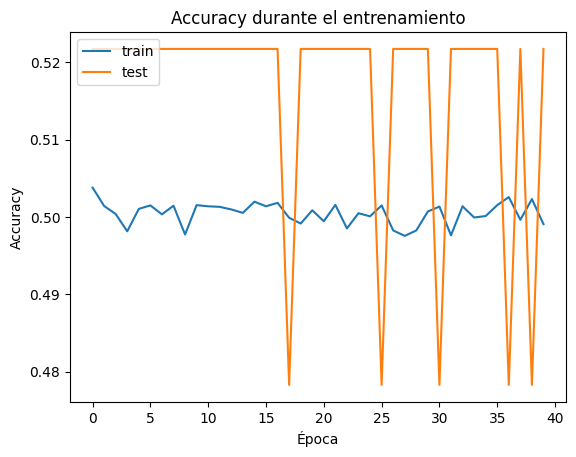

In [42]:
learning_curve(history_mlp_8)

**Red Neuronal 4.1:**
- MLP
- Capas ocultas: **20 capas densas**, 5 con 60 neuronas, 5 con 50 neuronas, 5 con 30 neuronas y 5 con 25 neuronas. 
- Capa de salida: Densa con 1 neurona. 
- Dropout: no utilizado.
- Función de activación: **"relu"** para las primeras capas. 
- **Épocas: 40.**
- Tamaño de Batch: 128

In [58]:
model_mlp_5 = Sequential([
    Flatten(input_shape=(SIZE,SIZE,IMAGES_CHANNELS)), 
    
    Dense(50, activation='relu'),
    Dense(50, activation='relu'),
    Dense(50, activation='relu'),
    Dense(50, activation='relu'),
    Dense(50, activation='relu'),
    Dense(25, activation='relu'),
    Dense(25, activation='relu'),
    Dense(25, activation='relu'),
    Dense(25, activation='relu'),
    Dense(25, activation='relu'),
    
    Dense(60, activation='relu'),
    Dense(60, activation='relu'),
    Dense(60, activation='relu'),
    Dense(60, activation='relu'),
    Dense(60, activation='relu'),
    Dense(30, activation='relu'),
    Dense(30, activation='relu'),
    Dense(30, activation='relu'),
    Dense(30, activation='relu'),
    Dense(30, activation='relu'),
    
    Dense(1, activation='sigmoid'),
])

model_mlp_5.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy',],
)
    
model_mlp_5.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_13 (Flatten)        (None, 14700)             0         
                                                                 
 dense_179 (Dense)           (None, 50)                735050    
                                                                 
 dense_180 (Dense)           (None, 50)                2550      
                                                                 
 dense_181 (Dense)           (None, 50)                2550      
                                                                 
 dense_182 (Dense)           (None, 50)                2550      
                                                                 
 dense_183 (Dense)           (None, 50)                2550      
                                                                 
 dense_184 (Dense)           (None, 25)              

In [59]:
history_mlp_9 = model_mlp_5.fit(
    train_generator,
    epochs=40,
    batch_size=128,
    validation_data=test_generator
)

Epoch 1/40
1076/1076 [==============================] - 34s 29ms/step - loss: 0.5230 - accuracy: 0.7217 - val_loss: 0.3883 - val_accuracy: 0.8198
Epoch 2/40
1076/1076 [==============================] - 32s 30ms/step - loss: 0.3912 - accuracy: 0.8191 - val_loss: 0.3545 - val_accuracy: 0.8328
Epoch 3/40
1076/1076 [==============================] - 32s 29ms/step - loss: 0.3570 - accuracy: 0.8353 - val_loss: 0.3590 - val_accuracy: 0.8365
Epoch 4/40
1076/1076 [==============================] - 32s 29ms/step - loss: 0.3452 - accuracy: 0.8410 - val_loss: 0.3862 - val_accuracy: 0.8124
Epoch 5/40
1076/1076 [==============================] - 32s 29ms/step - loss: 0.3343 - accuracy: 0.8460 - val_loss: 0.3372 - val_accuracy: 0.8523
Epoch 6/40
1076/1076 [==============================] - 32s 29ms/step - loss: 0.3220 - accuracy: 0.8520 - val_loss: 0.3118 - val_accuracy: 0.8594
Epoch 7/40
1076/1076 [==============================] - 32s 29ms/step - loss: 0.3199 - accuracy: 0.8522 - val_loss: 0.3560 -

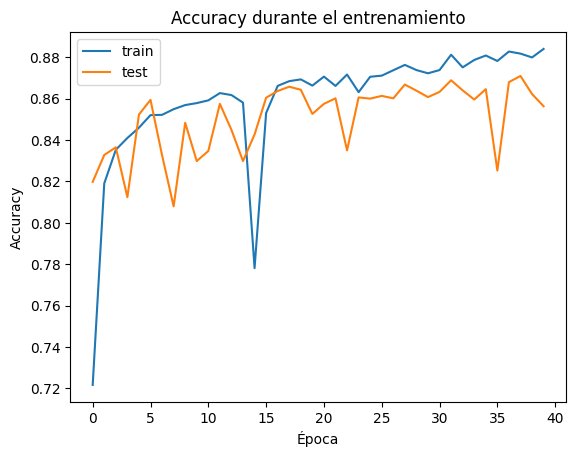

In [60]:
learning_curve(history_mlp_9)

### Resumen de los resultados para las redes **MLP**

| Red |                                                                                                                                                      Parámetros                                                                                                                                                     | Train - Loss | Train - Accuracy | Test - Loss | Test - Accuracy |
|:---:|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------:|:------------:|:----------------:|:-----------:|:---------------:|
|  1  |                                 - MLP<br>- Capas ocultas: 2 densas, con 20 neuronas y 15 neuronas. <br>- Capa de salida: Densa con 1 neurona. <br>- Dropout: no utilizado.<br>- Función de activación: "relu" para las primeras capas. <br>- Épocas: 10. <br>- Tamaño de Batch: 128                                 |      31%     |        85%       |     30%     |       85%       |
| 1.1 |                                    - MLP<br>- Capas ocultas: 2 densas, con 20 neuronas y 15 neuronas. <br>- Capa de salida: Densa con 1 neurona. <br>- **Dropout: 20%**<br>- Función de activación: "relu" para las primeras capas. <br>- Épocas: 10. <br>- Tamaño de Batch: 128                                    |      70%     |        50%       |     70%     |       52%       |
| 1.2 |                                  - MLP<br>- Capas ocultas: 2 densas, con 20 neuronas y 15 neuronas.<br>- Capa de salida: Densa con 1 neurona.<br>- Dropout: no utilizado.<br>- Función de activación: "relu" para las primeras capas.<br>- **Épocas: 20**<br>- Tamaño de Batch: 128                                 |      26%     |        88%       |     30%     |       87%       |
| 1.3 |                                  - MLP<br>- Capas ocultas: 2 densas, con 20 neuronas y 15 neuronas.<br>- Capa de salida: Densa con 1 neurona.<br>- Dropout: no utilizado.<br>- Función de activación: "relu" para las primeras capas.<br>- **Épocas: 80**<br>- Tamaño de Batch: 128                                 |      24%     |        89%       |     30%     |       86%       |
|  2  |                               - MLP<br>- Capas ocultas: 2 densas, con 20 neuronas y 15 neuronas. <br>- Capa de salida: Densa con 1 neurona. <br>- Dropout: no utilizado.<br>- Función de activación: **"tanh"** para las primeras capas. <br>- Épocas: 10. <br>- Tamaño de Batch: 128                               |      57%     |        73%       |     55%     |       75%       |
| 2.1 |                              - MLP<br>- Capas ocultas: 2 densas, con 20 neuronas y 15 neuronas. <br>- Capa de salida: Densa con 1 neurona. <br>- Dropout: no utilizado.<br>- Función de activación: **"tanh"** para las primeras capas. <br>- **Épocas: 30.**<br>- Tamaño de Batch: 128                             |      45%     |        82%       |     47%     |       80%       |
| 2.2 |                              - MLP<br>- Capas ocultas: 2 densas, con 20 neuronas y 15 neuronas. <br>- Capa de salida: Densa con 1 neurona. <br>- Dropout: no utilizado.<br>- Función de activación: **"tanh"** para las primeras capas. <br>- **Épocas: 80.**<br>- Tamaño de Batch: 128                             |      39%     |        85%       |     40%     |       85%       |
|  3  |              - MLP<br>- Capas ocultas: **5 capas densas** con 20 neuronas y **5 capas densas** con 15 neuronas.<br>- Capa de salida: Densa con 1 neurona. <br>- Dropout: no utilizado.<br>- Función de activación: **"relu"** para las primeras capas. <br>- **Épocas: 20.**<br>- Tamaño de Batch: 128              |      28%     |        87%       |     33%     |       84%       |
| 3.1 |              - MLP<br>- Capas ocultas: 5 capas densas con **50 neuronas** y 5 capas densas con **30 neuronas**. <br>- Capa de salida: Densa con 1 neurona. <br>- Dropout: no utilizado.<br>- Función de activación: **"relu"** para las primeras capas. <br>- **Épocas: 20.**<br>- Tamaño de Batch: 128             |      28%     |        87%       |     31%     |       86%       |
| 3.2 |                  - MLP<br>- Capas ocultas: 5 capas densas con 50 neuronas y 5 capas densas con 30 neuronas. <br>- Capa de salida: Densa con 1 neurona. <br>- Dropout: no utilizado.<br>- Función de activación: **"relu"** para las primeras capas. <br>- **Épocas: 40.**<br>- Tamaño de Batch: 128                 |      22%     |        90%       |     30%     |       87%       |
|  4  |             - MLP<br>- Capas ocultas: **10 capas densas** con 20 neuronas y **10 capas densas** con 15 neuronas.<br>- Capa de salida: Densa con 1 neurona. <br>- Dropout: no utilizado.<br>- Función de activación: **"relu"** para las primeras capas. <br>- **Épocas: 40.**<br>- Tamaño de Batch: 128             |      69%     |        50%       |     69%     |       52%       |
| 4.1 | - MLP<br>- Capas ocultas: **20 capas densas**, 5 con 60 neuronas, 5 con 50 neuronas, 5 con 30 neuronas y 5 con 25 neuronas. <br>- Capa de salida: Densa con 1 neurona. <br>- Dropout: no utilizado.<br>- Función de activación: **"relu"** para las primeras capas. <br>- **Épocas: 40.**<br>- Tamaño de Batch: 128 |      26%     |        88%       |     33%     |       86%       |

## - Convolutional Neural Networks

### Aumentación de datos

### Transfer Learning - VGG16

## 3 - Conclusiones

****Aca arranque****----------------------------------------------------------------------------------------------

**Red Neuronal 5:**  
En esta red vamos a mantener las mismas características que en la red neuronal 1, pero incluyendo una nueva capa convolucional.
- Convolucional
- Capas ocultas: 1 convolucional con 3 filtros de 4x4 y stride 1, max pooling de 4x4. 2 densas, con 20 neuronas y 15 neuronas
- Capa de salida: Densa con 1 neurona.
- Dropout: no utilizado.
- Función de activación: "relu" para las primeras capas. 
- Épocas: 10
- Tamaño de Batch: 128

In [38]:
model_conv_1 = Sequential([
    Convolution2D(input_shape=(SIZE,SIZE,IMAGES_CHANNELS), filters=3, kernel_size=(4, 4), strides=1, activation='relu'),
    MaxPooling2D(pool_size=(4, 4)),
    Flatten(),
    
    Dense(20, activation='relu'),
    Dense(15, activation='relu'),
    
    Dense(1, activation='sigmoid'),
])

model_conv_1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy',],
)
    
model_conv_1.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 67, 67, 3)         147       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 16, 16, 3)        0         
 2D)                                                             
                                                                 
 flatten_9 (Flatten)         (None, 768)               0         
                                                                 
 dense_27 (Dense)            (None, 20)                15380     
                                                                 
 dense_28 (Dense)            (None, 15)                315       
                                                                 
 dense_29 (Dense)            (None, 1)                 16        
                                                      

In [30]:
history_conv_1 = model_conv_1.fit(
    train_generator,
    epochs=10,
    batch_size=128,
    validation_data=test_generator
)

Epoch 1/10
1076/1076 [==============================] - 335s 310ms/step - loss: 0.4895 - accuracy: 0.7584 - val_loss: 0.4348 - val_accuracy: 0.8118
Epoch 2/10
1076/1076 [==============================] - 42s 39ms/step - loss: 0.3761 - accuracy: 0.8262 - val_loss: 0.3671 - val_accuracy: 0.8390
Epoch 3/10
1076/1076 [==============================] - 41s 38ms/step - loss: 0.3420 - accuracy: 0.8423 - val_loss: 0.3339 - val_accuracy: 0.8465
Epoch 4/10
1076/1076 [==============================] - 41s 38ms/step - loss: 0.3263 - accuracy: 0.8501 - val_loss: 0.3270 - val_accuracy: 0.8527
Epoch 5/10
1076/1076 [==============================] - 41s 38ms/step - loss: 0.3150 - accuracy: 0.8568 - val_loss: 0.3100 - val_accuracy: 0.8576
Epoch 6/10
1076/1076 [==============================] - 43s 40ms/step - loss: 0.3079 - accuracy: 0.8595 - val_loss: 0.3050 - val_accuracy: 0.8621
Epoch 7/10
1076/1076 [==============================] - 43s 40ms/step - loss: 0.3009 - accuracy: 0.8631 - val_loss: 0.3043

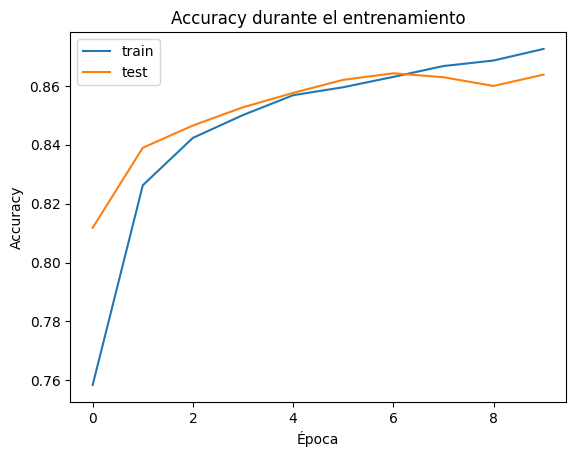

In [31]:
learning_curve(history_conv_1)

Podemos observar que los valores de accuracy son levemente mejores que sin la nueva capa convolucional. Se van a realizar algunas modificaciones en la capa convolucional para ver si aumentan los valores de la métrica.

**Red Neuronal 5.1:**  
Observando los resultados de la red neuronal 5, vamos a probar aumentar la cantidad de filtros en la capa convolucional.
- Convolucional
- Capas ocultas: 1 convolucional con **10 filtros** de 4x4 y stride 1, max pooling de 4x4. 2 densas, con 20 neuronas y 15 neuronas
- Capa de salida: Densa con 1 neurona.
- Dropout: no utilizado.
- Función de activación: "relu" para las primeras capas. 
- Épocas: 10
- Tamaño de Batch: 128

In [39]:
model_conv_2 = Sequential([
    Convolution2D(input_shape=(SIZE,SIZE,IMAGES_CHANNELS), filters=10, kernel_size=(4, 4), strides=1, activation='relu'),
    MaxPooling2D(pool_size=(4, 4)),
    Flatten(),
    
    Dense(20, activation='relu'),
    Dense(15, activation='relu'),
    
    Dense(1, activation='sigmoid'),
])

model_conv_2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy',],
)
    
model_conv_2.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 67, 67, 10)        490       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 16, 16, 10)       0         
 g2D)                                                            
                                                                 
 flatten_10 (Flatten)        (None, 2560)              0         
                                                                 
 dense_30 (Dense)            (None, 20)                51220     
                                                                 
 dense_31 (Dense)            (None, 15)                315       
                                                                 
 dense_32 (Dense)            (None, 1)                 16        
                                                     

In [40]:
history_conv_2 = model_conv_2.fit(
    train_generator,
    epochs=10,
    batch_size=128,
    validation_data=test_generator
)

Epoch 1/10
1076/1076 [==============================] - 44s 40ms/step - loss: 0.4148 - accuracy: 0.8043 - val_loss: 0.3218 - val_accuracy: 0.8501
Epoch 2/10
1076/1076 [==============================] - 44s 41ms/step - loss: 0.3106 - accuracy: 0.8592 - val_loss: 0.3074 - val_accuracy: 0.8570
Epoch 3/10
1076/1076 [==============================] - 43s 40ms/step - loss: 0.2813 - accuracy: 0.8747 - val_loss: 0.2797 - val_accuracy: 0.8714
Epoch 4/10
1076/1076 [==============================] - 43s 40ms/step - loss: 0.2659 - accuracy: 0.8813 - val_loss: 0.2807 - val_accuracy: 0.8715
Epoch 5/10
1076/1076 [==============================] - 43s 40ms/step - loss: 0.2540 - accuracy: 0.8870 - val_loss: 0.2580 - val_accuracy: 0.8851
Epoch 6/10
1076/1076 [==============================] - 43s 40ms/step - loss: 0.2463 - accuracy: 0.8911 - val_loss: 0.2576 - val_accuracy: 0.8866
Epoch 7/10
1076/1076 [==============================] - 43s 40ms/step - loss: 0.2400 - accuracy: 0.8938 - val_loss: 0.2589 -

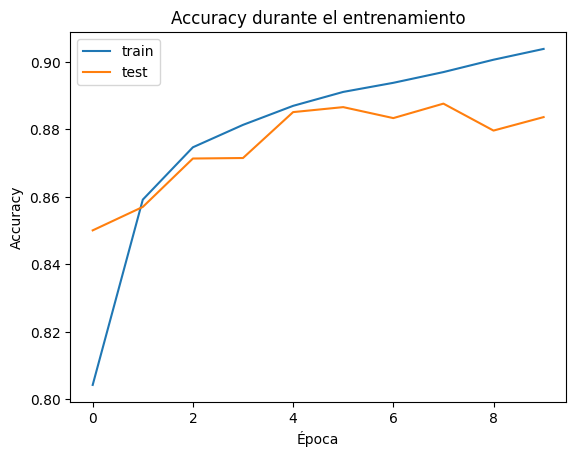

In [41]:
learning_curve(history_conv_2)

Podemos observar que aumentando la cantidad de filtros de 3 a 10 aumentó el valor de accuracy y disminuyó el valor de loss. Entonces, podemos decir que que en este caso, aumentar los filtros puede ser una mejor opción.

**Red Neuronal 5.2:**  
Observando los resultados de la red neuronal 5.1, vamos a probar aumentar el tamaño del kernel a 6x6 de la capa convolucional.
- Convolucional
- Capas ocultas: 1 convolucional con 10 filtros de **6x6** y stride 1, max pooling de 4x4. 2 densas, con 20 neuronas y 15 neuronas
- Capa de salida: Densa con 1 neurona.
- Dropout: no utilizado.
- Función de activación: "relu" para las primeras capas. 
- Épocas: 10
- Tamaño de Batch: 128

In [49]:
model_conv_3 = Sequential([
    Convolution2D(input_shape=(SIZE,SIZE,IMAGES_CHANNELS), filters=10, kernel_size=(6, 6), strides=1, activation='relu'),
    MaxPooling2D(pool_size=(4, 4)),
    Flatten(),
    
    Dense(20, activation='relu'),
    Dense(15, activation='relu'),
    
    Dense(1, activation='sigmoid'),
])

model_conv_3.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy',],
)
    
model_conv_3.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 65, 65, 10)        1090      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 16, 16, 10)       0         
 g2D)                                                            
                                                                 
 flatten_15 (Flatten)        (None, 2560)              0         
                                                                 
 dense_45 (Dense)            (None, 20)                51220     
                                                                 
 dense_46 (Dense)            (None, 15)                315       
                                                                 
 dense_47 (Dense)            (None, 1)                 16        
                                                     

In [50]:
history_conv_3 = model_conv_3.fit(
    train_generator,
    epochs=10,
    batch_size=128,
    validation_data=test_generator
)

Epoch 1/10
1076/1076 [==============================] - 344s 319ms/step - loss: 0.4079 - accuracy: 0.8048 - val_loss: 0.3133 - val_accuracy: 0.8582
Epoch 2/10
1076/1076 [==============================] - 55s 51ms/step - loss: 0.3014 - accuracy: 0.8641 - val_loss: 0.2878 - val_accuracy: 0.8751
Epoch 3/10
1076/1076 [==============================] - 55s 51ms/step - loss: 0.2740 - accuracy: 0.8782 - val_loss: 0.2967 - val_accuracy: 0.8702
Epoch 4/10
1076/1076 [==============================] - 55s 51ms/step - loss: 0.2593 - accuracy: 0.8868 - val_loss: 0.2941 - val_accuracy: 0.8709
Epoch 5/10
1076/1076 [==============================] - 55s 51ms/step - loss: 0.2500 - accuracy: 0.8890 - val_loss: 0.2581 - val_accuracy: 0.8884
Epoch 6/10
1076/1076 [==============================] - 55s 51ms/step - loss: 0.2392 - accuracy: 0.8953 - val_loss: 0.2524 - val_accuracy: 0.8931
Epoch 7/10
1076/1076 [==============================] - 56s 52ms/step - loss: 0.2345 - accuracy: 0.8967 - val_loss: 0.2469

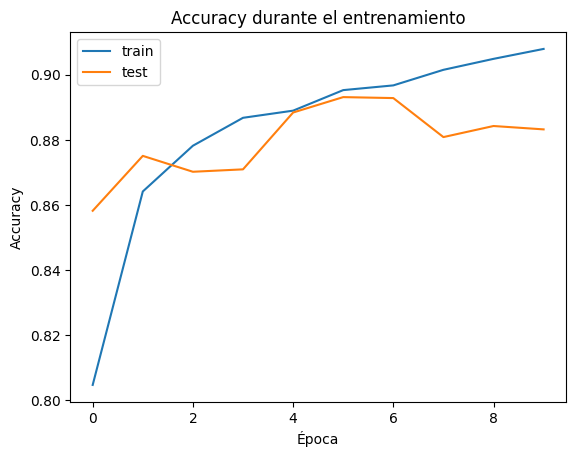

In [55]:
learning_curve(history_conv_3)

**Red Neuronal 5.3:**  
Observando los resultados de la red neuronal 5.1 y 5.2, vamos a probar aumentar el tamaño del kernel a 8x8 de la capa convolucional.
- Convolucional
- Capas ocultas: 1 convolucional con 10 filtros de **8x8** y stride 1, max pooling de 4x4. 2 densas, con 20 neuronas y 15 neuronas
- Capa de salida: Densa con 1 neurona.
- Dropout: no utilizado.
- Función de activación: "relu" para las primeras capas. 
- Épocas: 10
- Tamaño de Batch: 128

In [53]:
model_conv_5 = Sequential([
    Convolution2D(input_shape=(SIZE,SIZE,IMAGES_CHANNELS), filters=10, kernel_size=(8, 8), strides=1, activation='relu'),
    MaxPooling2D(pool_size=(4, 4)),
    Flatten(),
    
    Dense(20, activation='relu'),
    Dense(15, activation='relu'),
    
    Dense(1, activation='sigmoid'),
])

model_conv_5.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy',],
)
    
model_conv_5.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 63, 63, 10)        1930      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 15, 15, 10)       0         
 g2D)                                                            
                                                                 
 flatten_17 (Flatten)        (None, 2250)              0         
                                                                 
 dense_51 (Dense)            (None, 20)                45020     
                                                                 
 dense_52 (Dense)            (None, 15)                315       
                                                                 
 dense_53 (Dense)            (None, 1)                 16        
                                                     

In [54]:
history_conv_5 = model_conv_5.fit(
    train_generator,
    epochs=10,
    batch_size=128,
    validation_data=test_generator
)

Epoch 1/10
1076/1076 [==============================] - 75s 69ms/step - loss: 0.3902 - accuracy: 0.8160 - val_loss: 0.3176 - val_accuracy: 0.8542
Epoch 2/10
1076/1076 [==============================] - 74s 69ms/step - loss: 0.2993 - accuracy: 0.8648 - val_loss: 0.2866 - val_accuracy: 0.8677
Epoch 3/10
1076/1076 [==============================] - 76s 71ms/step - loss: 0.2810 - accuracy: 0.8740 - val_loss: 0.2714 - val_accuracy: 0.8782
Epoch 4/10
1076/1076 [==============================] - 72s 67ms/step - loss: 0.2668 - accuracy: 0.8803 - val_loss: 0.2741 - val_accuracy: 0.8767
Epoch 5/10
1076/1076 [==============================] - 72s 67ms/step - loss: 0.2561 - accuracy: 0.8858 - val_loss: 0.2662 - val_accuracy: 0.8798
Epoch 6/10
1076/1076 [==============================] - 72s 67ms/step - loss: 0.2482 - accuracy: 0.8905 - val_loss: 0.2598 - val_accuracy: 0.8848
Epoch 7/10
1076/1076 [==============================] - 72s 67ms/step - loss: 0.2394 - accuracy: 0.8940 - val_loss: 0.2771 -

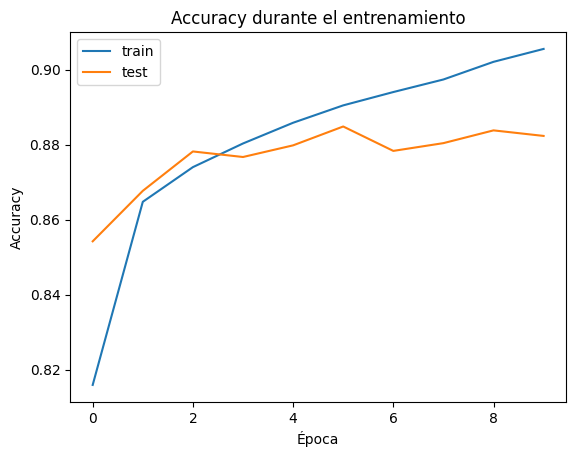

In [57]:
learning_curve(history_conv_5)

Comparando las redes **5.1**, **5.2** y **5.3** podemos observar que cambiando el tamaño del kernel, los resultados obtenidos en accuracy son muy similares. Por lo tanto, en nuestro caso, no afecta demasiado el tamaño del kernel para las métricas, pero si aumenta considerablemente el tiempo de entrenamiento. 

**Red Neuronal 5.4:**  
Partiendo de la red 5.1, vamos a probar cambiar el stride de la capa de convolución a 2 para ver como afecta a los resultados.
- Convolucional
- Capas ocultas: 1 convolucional con 10 filtros de 4x4 y **stride 2**, max pooling de 4x4. 2 densas, con 20 neuronas y 15 neuronas
- Capa de salida: Densa con 1 neurona.
- Dropout: no utilizado.
- Función de activación: "relu" para las primeras capas. 
- Épocas: 10
- Tamaño de Batch: 128

In [60]:
model_conv_6 = Sequential([
    Convolution2D(input_shape=(SIZE,SIZE,IMAGES_CHANNELS), filters=10, kernel_size=(4, 4), strides=2, activation='relu'),
    MaxPooling2D(pool_size=(4, 4)),
    Flatten(),
    
    Dense(20, activation='relu'),
    Dense(15, activation='relu'),
    
    Dense(1, activation='sigmoid'),
])

model_conv_6.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy',],
)
    
model_conv_6.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 34, 34, 10)        490       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 8, 8, 10)         0         
 g2D)                                                            
                                                                 
 flatten_18 (Flatten)        (None, 640)               0         
                                                                 
 dense_54 (Dense)            (None, 20)                12820     
                                                                 
 dense_55 (Dense)            (None, 15)                315       
                                                                 
 dense_56 (Dense)            (None, 1)                 16        
                                                     

In [61]:
history_conv_6 = model_conv_6.fit(
    train_generator,
    epochs=10,
    batch_size=128,
    validation_data=test_generator
)

Epoch 1/10
1076/1076 [==============================] - 39s 36ms/step - loss: 0.4886 - accuracy: 0.7555 - val_loss: 0.4101 - val_accuracy: 0.8145
Epoch 2/10
1076/1076 [==============================] - 38s 36ms/step - loss: 0.3838 - accuracy: 0.8227 - val_loss: 0.3933 - val_accuracy: 0.8165
Epoch 3/10
1076/1076 [==============================] - 42s 39ms/step - loss: 0.3584 - accuracy: 0.8351 - val_loss: 0.3526 - val_accuracy: 0.8384
Epoch 4/10
1076/1076 [==============================] - 43s 40ms/step - loss: 0.3452 - accuracy: 0.8418 - val_loss: 0.3591 - val_accuracy: 0.8331
Epoch 5/10
1076/1076 [==============================] - 43s 40ms/step - loss: 0.3359 - accuracy: 0.8461 - val_loss: 0.3337 - val_accuracy: 0.8507
Epoch 6/10
1076/1076 [==============================] - 42s 39ms/step - loss: 0.3269 - accuracy: 0.8504 - val_loss: 0.3284 - val_accuracy: 0.8482
Epoch 7/10
1076/1076 [==============================] - 43s 40ms/step - loss: 0.3188 - accuracy: 0.8537 - val_loss: 0.3206 -

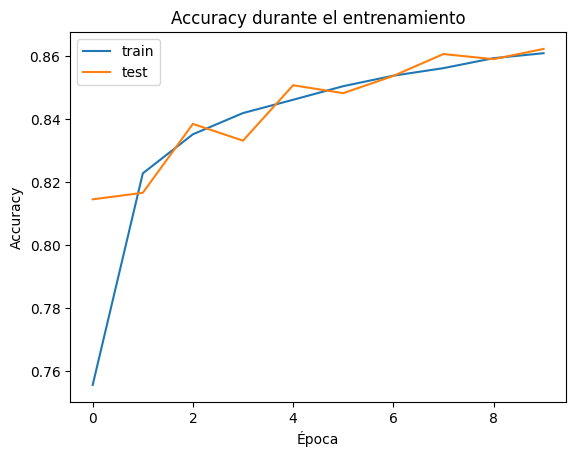

In [62]:
learning_curve(history_conv_6)

Comparando la red **5.1** y **5.4**, si cambiamos el stride de 1 a 2 observamos que los valores de accuracy caen.

**Red Neuronal 6:**  
En esta red vamos a añadir más capas convolucionales para ver que resultados obtenemos. Las nuevas capas tendrán las mismas características que en la red 5.
- Convolucional
- Capas ocultas: **3 convolucionales** con 4 filtros de 4x4 y stride 1, max pooling de 4x4. 2 densas, con 20 neuronas y 15 neuronas
- Capa de salida: Densa con 1 neurona.
- Dropout: no utilizado.
- Función de activación: "relu" para las primeras capas. 
- Épocas: 10
- Tamaño de Batch: 128

In [91]:
model_conv_7 = Sequential([
    Convolution2D(input_shape=(SIZE,SIZE,IMAGES_CHANNELS), filters=3, kernel_size=(4, 4), strides=1, activation='relu'),
    Convolution2D(filters=3, kernel_size=(4, 4), strides=1, activation='relu'),
    Convolution2D(filters=3, kernel_size=(4, 4), strides=1, activation='relu'),
    MaxPooling2D(pool_size=(4, 4)),
    Flatten(),
    
    Dense(20, activation='relu'),
    Dense(15, activation='relu'),
    
    Dense(1, activation='sigmoid'),
])

model_conv_7.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy',],
)
    
model_conv_7.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_47 (Conv2D)          (None, 67, 67, 3)         147       
                                                                 
 conv2d_48 (Conv2D)          (None, 64, 64, 3)         147       
                                                                 
 conv2d_49 (Conv2D)          (None, 61, 61, 3)         147       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 15, 15, 3)        0         
 g2D)                                                            
                                                                 
 flatten_27 (Flatten)        (None, 675)               0         
                                                                 
 dense_81 (Dense)            (None, 20)                13520     
                                                     

In [92]:
history_conv_7 = model_conv_7.fit(
    train_generator,
    epochs=10,
    batch_size=128,
    validation_data=test_generator
)

Epoch 1/10
1076/1076 [==============================] - 85s 78ms/step - loss: 0.4311 - accuracy: 0.7916 - val_loss: 0.3259 - val_accuracy: 0.8557
Epoch 2/10
1076/1076 [==============================] - 83s 77ms/step - loss: 0.3220 - accuracy: 0.8543 - val_loss: 0.2958 - val_accuracy: 0.8664
Epoch 3/10
1076/1076 [==============================] - 84s 78ms/step - loss: 0.2986 - accuracy: 0.8658 - val_loss: 0.2937 - val_accuracy: 0.8658
Epoch 4/10
1076/1076 [==============================] - 82s 76ms/step - loss: 0.2861 - accuracy: 0.8709 - val_loss: 0.2796 - val_accuracy: 0.8714
Epoch 5/10
1076/1076 [==============================] - 82s 76ms/step - loss: 0.2788 - accuracy: 0.8746 - val_loss: 0.2952 - val_accuracy: 0.8714
Epoch 6/10
1076/1076 [==============================] - 82s 76ms/step - loss: 0.2740 - accuracy: 0.8773 - val_loss: 0.2698 - val_accuracy: 0.8786
Epoch 7/10
1076/1076 [==============================] - 82s 76ms/step - loss: 0.2683 - accuracy: 0.8784 - val_loss: 0.2658 -

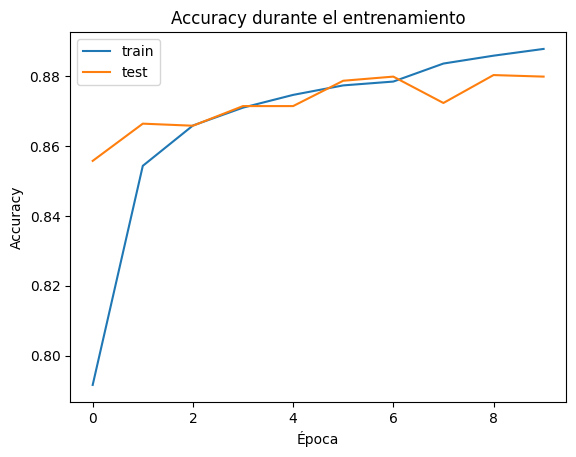

In [93]:
learning_curve(history_conv_7)

Observando los resultados obtenidos por la red 5 y la 6, podemos ver que agregar más capas de convolución mejoran los resultados obtenidos. Esto es un factor a tener en cuenta para intentar mejorar una red. 

**Red Neuronal 6.1:**  
En esta red vamos repetir la anterior pero utilizando la técnica de dropout para evitar el overfitting.
- Convolucional
- Capas ocultas: 3 convolucionales con 4 filtros de 4x4 y stride 1, max pooling de 4x4. 2 densas, con 20 neuronas y 15 neuronas
- Capa de salida: Densa con 1 neurona.
- Dropout: **0.25** en cada capa.
- Función de activación: "relu" para las primeras capas. 
- Épocas: 10
- Tamaño de Batch: 128

In [22]:
model_conv_8 = Sequential([
    Convolution2D(input_shape=(SIZE,SIZE,IMAGES_CHANNELS), filters=3, kernel_size=(4, 4), strides=1, activation='relu'),
    Dropout(0.25),
    Convolution2D(filters=3, kernel_size=(4, 4), strides=1, activation='relu'),
    Dropout(0.25),
    Convolution2D(filters=3, kernel_size=(4, 4), strides=1, activation='relu'),
    Dropout(0.25),
    MaxPooling2D(pool_size=(4, 4)),
    Flatten(),
    
    Dense(20, activation='relu'),
    Dropout(0.25),
    Dense(15, activation='relu'),
    Dropout(0.25),
    
    Dense(1, activation='sigmoid'),
])

model_conv_8.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy',],
)
    
model_conv_8.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 67, 67, 3)         147       
                                                                 
 dropout (Dropout)           (None, 67, 67, 3)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 3)         147       
                                                                 
 dropout_1 (Dropout)         (None, 64, 64, 3)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 61, 61, 3)         147       
                                                                 
 dropout_2 (Dropout)         (None, 61, 61, 3)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 3)        0

In [23]:
history_conv_8 = model_conv_8.fit(
    train_generator,
    epochs=10,
    batch_size=128,
    validation_data=test_generator
)

Epoch 1/10
1076/1076 [==============================] - 98s 90ms/step - loss: 0.4906 - accuracy: 0.7511 - val_loss: 0.3721 - val_accuracy: 0.8258
Epoch 2/10
1076/1076 [==============================] - 97s 90ms/step - loss: 0.3743 - accuracy: 0.8270 - val_loss: 0.3365 - val_accuracy: 0.8541
Epoch 3/10
1076/1076 [==============================] - 95s 88ms/step - loss: 0.3472 - accuracy: 0.8443 - val_loss: 0.3119 - val_accuracy: 0.8638
Epoch 4/10
1076/1076 [==============================] - 96s 89ms/step - loss: 0.3330 - accuracy: 0.8513 - val_loss: 0.3235 - val_accuracy: 0.8570
Epoch 5/10
1076/1076 [==============================] - 95s 89ms/step - loss: 0.3246 - accuracy: 0.8557 - val_loss: 0.3228 - val_accuracy: 0.8588
Epoch 6/10
1076/1076 [==============================] - 95s 88ms/step - loss: 0.3180 - accuracy: 0.8583 - val_loss: 0.3314 - val_accuracy: 0.8532
Epoch 7/10
1076/1076 [==============================] - 95s 88ms/step - loss: 0.3152 - accuracy: 0.8600 - val_loss: 0.2922 -

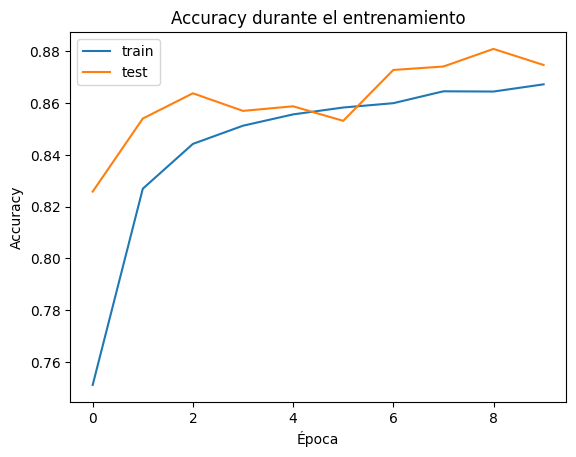

In [24]:
learning_curve(history_conv_8)

**Red Neuronal 7:**  
En esta red vamos añadir 2 capas de convolución y aplicandoles los mejores parametros que hemos obtenido en entrenamientos anteriores de redes convolucionales, que mejoraban los valores de accuracy.
- Convolucional
- Capas ocultas: **2 convolucionales** con 10 filtros de 4x4 y stride 1, **3 convolucionales** con 4 filtros de 4x4 y stride 1, max pooling de 4x4. 2 densas, con 20 neuronas y 15 neuronas
- Capa de salida: Densa con 1 neurona.
- Dropout: **0.2** en cada capa.
- Función de activación: "relu" para las primeras capas. 
- Épocas: 10
- Tamaño de Batch: 128

In [87]:
model_conv_9 = Sequential([
    Convolution2D(input_shape=(SIZE,SIZE,IMAGES_CHANNELS), filters=10, kernel_size=(4, 4), strides=1, activation='relu'),
    Dropout(0.2),
    Convolution2D(filters=10, kernel_size=(4, 4), strides=1, activation='relu'),
    Dropout(0.2),
    Convolution2D(filters=3, kernel_size=(4, 4), strides=1, activation='relu'),
    Dropout(0.2),
    Convolution2D(filters=3, kernel_size=(4, 4), strides=1, activation='relu'),
    Dropout(0.2),
    Convolution2D(filters=3, kernel_size=(4, 4), strides=1, activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(4, 4)),
    Flatten(),
    
    Dense(20, activation='relu'),
    Dropout(0.2),
    Dense(15, activation='relu'),
    Dropout(0.2),
    
    Dense(1, activation='sigmoid'),
])

model_conv_9.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy',],
)
    
model_conv_9.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 67, 67, 10)        490       
                                                                 
 dropout_25 (Dropout)        (None, 67, 67, 10)        0         
                                                                 
 conv2d_43 (Conv2D)          (None, 64, 64, 10)        1610      
                                                                 
 dropout_26 (Dropout)        (None, 64, 64, 10)        0         
                                                                 
 conv2d_44 (Conv2D)          (None, 61, 61, 3)         483       
                                                                 
 dropout_27 (Dropout)        (None, 61, 61, 3)         0         
                                                                 
 conv2d_45 (Conv2D)          (None, 58, 58, 3)       

In [88]:
history_conv_9 = model_conv_9.fit(
    train_generator,
    epochs=10,
    batch_size=128,
    validation_data=test_generator
)

Epoch 1/10
1076/1076 [==============================] - 542s 503ms/step - loss: 0.5095 - accuracy: 0.7288 - val_loss: 0.3605 - val_accuracy: 0.8449
Epoch 2/10
1076/1076 [==============================] - 231s 214ms/step - loss: 0.3634 - accuracy: 0.8366 - val_loss: 0.3247 - val_accuracy: 0.8618
Epoch 3/10
1076/1076 [==============================] - 230s 214ms/step - loss: 0.3315 - accuracy: 0.8517 - val_loss: 0.2917 - val_accuracy: 0.8734
Epoch 4/10
1076/1076 [==============================] - 230s 214ms/step - loss: 0.3233 - accuracy: 0.8555 - val_loss: 0.2818 - val_accuracy: 0.8805
Epoch 5/10
1076/1076 [==============================] - 236s 219ms/step - loss: 0.3102 - accuracy: 0.8612 - val_loss: 0.3026 - val_accuracy: 0.8795
Epoch 6/10
1076/1076 [==============================] - 235s 218ms/step - loss: 0.3003 - accuracy: 0.8670 - val_loss: 0.2684 - val_accuracy: 0.8820
Epoch 7/10
1076/1076 [==============================] - 233s 217ms/step - loss: 0.2948 - accuracy: 0.8705 - val_

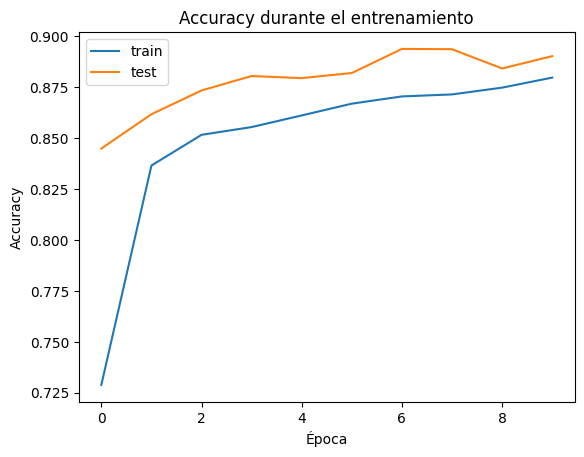

In [89]:
learning_curve(history_conv_9)

Después de entrenar el modelo, observamos que las métricas mejoraron con respecto al modelo 6.1. Si bien vemos que los resultados obtenidos pueden ser un poco menores que en modelos anteriores, se debe a que aplicamos la técnica de dropout para evitar el overfitting.  
